In [1]:
from virusPropagationModel import *
import VPM_plotting as vpm_plot
%matplotlib inline
%load_ext autoreload
import glob
import os
import copy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import numpy as np
#%load_ext memory_profiler

In [2]:
geopath = 'datafiles/'
geofiles = {0:'Buildings_Gangelt_MA_1.csv',
            1:'Buildings_Gangelt_MA_3.csv',
           }         

# Build world 

### Choose which world to initate

In [3]:
#world_to_pick = 0 ## choosing large version
world_to_pick = 1 ## choosing small version

### Initiate the selected world

In [4]:
# intialize world without infections
modeledWorld = ModeledPopulatedWorld(1000, 0, world_from_file=True, geofile_name=geopath+geofiles[world_to_pick], agent_agent_infection=True, input_schedules='schedules_v2')
n_people = modeledWorld.number_of_people
print('Number of agents: '+ str(n_people))

Number of agents: 1002


In [5]:
# define funtion to infect susceptible agents
def infect_world(world, IDs=[1]):
    ID_list = world.get_remaining_possible_initial_infections(IDs)
    world.initialize_infection(specific_people_ids=ID_list)

# Run initial simulation

#### Define Simulation characteristics

In [6]:
timesteps_initial_sim=1500
general_infectivity=0.3
general_interaction_frequency=2

In [7]:
# copy initialized world and infect agents in that copy
world_to_use = copy.deepcopy(modeledWorld)

n_initially_infected=4

infect_world(world_to_use, IDs=[i+1 for i in range(n_initially_infected)])

amount of initially recovered agents: 0


#### Set-up simulation with specified characteristics

In [8]:
simulation_initial_wave = Simulation(world_to_use, timesteps_initial_sim, run_immediately=False)

#### Run simulation

In [9]:
simulation_initial_wave.simulate()

#### Plot status-trajectories

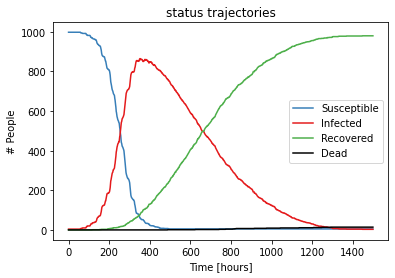

In [10]:
simulation_initial_wave.plot_status_timecourse()

# Derive ordered lists of agents for different vaccination-strategies

## Sorting-strategies, based on previous simulation

### Sorted by forecasted infection wave

In [11]:
def get_previous_infections(previous_simulation):
    df_inf = previous_simulation.get_infection_event_information()
    infected = list(df_inf['h_ID'].values)
    all_agents = infected+[a.ID for a in previous_simulation.people if a.ID not in infected]
    return all_agents

In [12]:
agents_forecasted = get_previous_infections(simulation_initial_wave)

### Sorted by over-representation (agent types)

In [13]:
def get_ids_by_agent_type(world):
    agent_types = ['under_age', 'adult', 'teacher', 'medical_professional', 'public_worker', 'pensioner']
    ids_by_type = {s_type:[] for s_type in agent_types}
    for p in world.people:
        ids_by_type[p.schedule['type']].append(p.ID)
    ordered_ids = []
    for s_type in agent_types:
        ordered_ids.extend(ids_by_type[s_type])
    return ordered_ids

In [14]:
agents_by_type = get_ids_by_agent_type(modeledWorld)

### Sorted by Interactivity

In [15]:
def get_ids_by_interactions(simulation_no_infections):
    contacts = simulation_no_infections.get_contact_distributions(min_t=0, max_t=168)[1]
    contacts_mean = contacts.groupby('ID').mean()
    contacts_mean.reset_index(inplace=True)
    contacts_sorted = contacts_mean.sort_values('interactions', axis=0, ascending=False)
    to_recover_list = list(contacts_sorted['ID'].values)
    return to_recover_list

In [16]:
# run simulation without infections to get interaction patterns
uninfectedWorld = copy.deepcopy(modeledWorld)
simulation_no_infections = Simulation(uninfectedWorld, 170)

In [17]:
agents_by_interactions = get_ids_by_interactions(simulation_no_infections)

## Sorting-strategies, based on population-structure

### Sorted by household

In [18]:
def get_ids_by_households(world):
    ai = world.get_agent_info()
    home_count_dict = dict(zip(list(ai.groupby('Home').count().index), list(ai.groupby('Home').count()['ID'])))
    ai['Home_size']=ai['Home'].map(home_count_dict)

    ai_sorted = ai.sort_values('Home')
    home_list = ai_sorted['Home'].values

    count_list=[]
    predecessor = 0
    count = 1
    for x in home_list:
        if x == predecessor:
            count +=1
        else:
            count = 1
        count_list.append(count)
        predecessor = x

    ai_sorted['Home_position'] = count_list

    ai_sorted.sort_values('Home_position') ## dataframe
    households_sorted = ai_sorted.sort_values(by=['Home_position'])
    to_recover_list = list(households_sorted['ID']) ### id list
    return to_recover_list

In [19]:
agents_by_households = get_ids_by_households(modeledWorld)

### Sorted by age

In [20]:
def get_ids_by_age(world):
    ages_and_ids = [(p.age, p.ID) for p in world.people]
    ages_and_ids_df = pd.DataFrame(ages_and_ids, columns=['age','id'])
    ages_and_ids_df.sort_values('age', ascending=False, inplace=True)
    to_recover_list = list(ages_and_ids_df['id'])
    return to_recover_list

In [21]:
agents_by_age = get_ids_by_age(modeledWorld)

## Random sorting

In [22]:
def get_random_id_list(world):
    agent_ids = [p.ID for p in world.people]
    random.shuffle(agent_ids)
    return agent_ids

In [23]:
agents_random = get_random_id_list(modeledWorld)

# Run vaccination-fraction screens for different strategies

In [24]:
# define function to vaccinate list of agents
def vaccinate_world(world, frac, ordered_agents):
    agents_to_vaccinate = ordered_agents[:int(frac*len(ordered_agents))]
    for p in world.people:
        if p.ID in agents_to_vaccinate:
            p.set_initially_recovered()

In [43]:
agent_orders = {'forecasted':agents_forecasted, 'overrepresentation':agents_by_type,
                'interactions':agents_by_interactions, 'households':agents_by_households,
                'age':agents_by_age, 'random':agents_random}

In [44]:
# get vaccinated fractions to simulate 
fractions = np.arange(0.1, 0.91, 0.2)

In [50]:
# loop over fractions, vaccinate and simulate
def simulate_fractions(modeledWorld, ordered_agents, fractions, n_initially_infected=4, timesteps_vaccination_sim=1000):
    results=pd.DataFrame(columns=['fraction','infected','icued','dead'])
    for frac in fractions:
        world_to_use = copy.deepcopy(modeledWorld)
        vaccinate_world(world_to_use, frac, ordered_agents)
        infect_world(world_to_use, IDs=[i+1 for i in range(n_initially_infected)])
        simulation_vaccinated_fraction = Simulation(world_to_use, timesteps_vaccination_sim)
        cummulative_flags = simulation_vaccinated_fraction.get_flag_sums_over_time(specific_flags=['ICUed'])
        dead_agents = simulation_vaccinated_fraction.get_status_trajectories(specific_statuses=['D'])['D']['D'].iloc[-1]
        infected_agents = simulation_vaccinated_fraction.get_infection_event_information().shape[0]
        icued_agents = cummulative_flags['ICUed'].max()
        results.loc[frac,'fraction']=frac
        results.loc[frac,'infected']=infected_agents
        results.loc[frac,'icued']=icued_agents
        results.loc[frac,'dead']=dead_agents
    return results

In [51]:
strategies_to_test = ['forecasted', 'interactions']
results_dict = {strategy: simulate_fractions(modeledWorld, agent_orders[strategy], fractions) for strategy in strategies_to_test}

amount of initially recovered agents: 100
amount of initially recovered agents: 300
amount of initially recovered agents: 501
amount of initially recovered agents: 701
amount of initially recovered agents: 901
amount of initially recovered agents: 100
list of initial infected changed from  [1, 2, 3, 4]  to  [3, 4, 5, 6]
amount of initially recovered agents: 300
list of initial infected changed from  [1, 2, 3, 4]  to  [3, 6, 7, 8]
amount of initially recovered agents: 501
list of initial infected changed from  [1, 2, 3, 4]  to  [3, 6, 7, 8]
amount of initially recovered agents: 701
list of initial infected changed from  [1, 2, 3, 4]  to  [9, 16, 17, 24]
amount of initially recovered agents: 901
list of initial infected changed from  [1, 2, 3, 4]  to  [17, 26, 43, 77]


In [52]:
results_dict

{'forecasted':     fraction infected icued dead
 0.1      0.1      889    12    6
 0.3      0.3      674    10    8
 0.5      0.5      450     4    2
 0.7      0.7      146     1    0
 0.9      0.9        0     0    0,
 'interactions':     fraction infected icued dead
 0.1      0.1      886     7    7
 0.3      0.3      672     7    6
 0.5      0.5      415     7    1
 0.7      0.7        3     0    0
 0.9      0.9        0     1    1}

# Plot results of vaccination screens

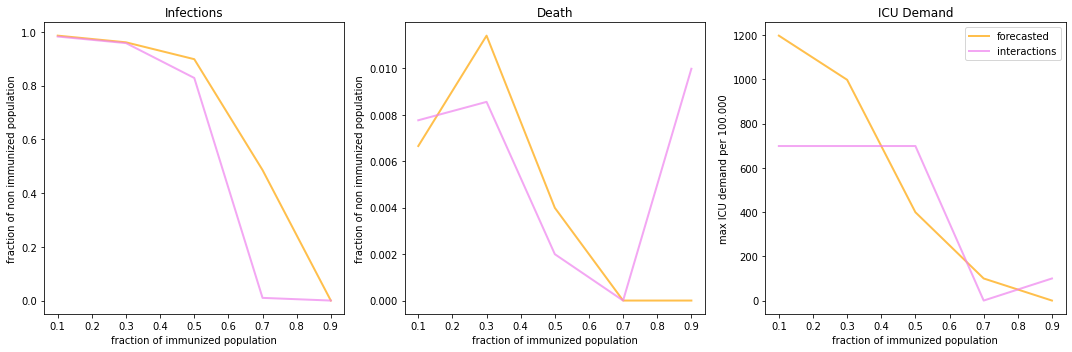

In [53]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

colors = {'random':'lightseagreen', 'interactions':'violet', 'age':'gold',
          'overrepresentation':'royalblue', 'households':'lightgreen', 'forecasted':'orange'}

for strategy in results_dict:
    fractions = results_dict[strategy]['fraction']
    axs[0].plot(fractions, results_dict[strategy]['infected']/(modeledWorld.number_of_people*(1-fractions)),
                label=strategy, lw=2, alpha=0.7, color=colors[strategy])
    axs[1].plot(fractions, results_dict[strategy]['dead']/(modeledWorld.number_of_people*(1-fractions)),
                label=strategy, lw=2, alpha=0.7, color=colors[strategy])
    axs[2].plot(fractions, (results_dict[strategy]['icued']/modeledWorld.number_of_people)*100000.0,
                label=strategy, lw=2, alpha=0.7, color=colors[strategy])
    
for ax in axs:
    ax.set_xlabel('fraction of immunized population')
    
axs[0].set_ylabel('fraction of non immunized population')
axs[1].set_ylabel('fraction of non immunized population')
axs[2].set_ylabel('max ICU demand per 100.000')

axs[0].set_title('Infections')
axs[1].set_title('Death')
axs[2].set_title('ICU Demand')

plt.legend()

plt.tight_layout()